# Huấn Luyện Mô Hình Random Forest
## Phân Loại Phòng Khách Sạn - Random Forest Training Pipeline

## Bước 1: Import Thư Viện

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')
import os

# Cài đặt style cho các biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Các thư viện được import thành công!")

✓ Các thư viện được import thành công!


## Bước 2: Load Dữ Liệu Đã Xử Lý

In [4]:
# 2.1: Tải dữ liệu đã xử lý từ bước Processing
print("="*70)
print("TẢI DỮ LIỆU ĐÃ XỬ LÝ")
print("="*70)

data_dir = '../Data'
train_processed_path = f'{data_dir}/train_processed.csv'
val_processed_path = f'{data_dir}/val_processed.csv'

# Kiểm tra xem file có tồn tại không
if not os.path.exists(train_processed_path):
    print(f"⚠ Cảnh báo: Không tìm thấy {train_processed_path}")
    print(f"Đang tìm kiếm trong ./Data/...")
    data_dir = './Data'
    train_processed_path = f'{data_dir}/train_processed.csv'
    val_processed_path = f'{data_dir}/val_processed.csv'

# Tải dữ liệu
train_data = pd.read_csv(train_processed_path)
val_data = pd.read_csv(val_processed_path)

print(f"\n✓ Kích thước Dữ liệu Train: {train_data.shape}")
print(f"✓ Kích thước Dữ liệu Val: {val_data.shape}")

print("\n5 hàng đầu của Train:")
print(train_data.head())

TẢI DỮ LIỆU ĐÃ XỬ LÝ

✓ Kích thước Dữ liệu Train: (8495, 23)
✓ Kích thước Dữ liệu Val: (1820, 23)

5 hàng đầu của Train:
   Final Price  Max People   Area_m2  price_per_m2  m2_per_person  \
0     0.468328    1.081911  0.461036      0.269550      -0.559756   
1     0.200077    2.315414 -0.817195      0.605604      -1.034214   
2    -0.238358   -1.385095 -0.135472     -0.248574       1.785994   
3     2.382831    1.081911  0.120174      2.258149      -0.652657   
4     0.195036    0.465159 -0.391118      0.332061      -0.652657   

   num_facilities  has_luxury_keyword   is_king  is_queen  is_double  ...  \
0       -0.048631            0.772143 -0.295685 -0.200404  -1.595460  ...   
1        0.043810            0.772143 -0.295685  4.989929   0.626778  ...   
2        1.153102           -1.295097 -0.295685 -0.200404   0.626778  ...   
3        0.968220            0.772143 -0.295685 -0.200404   0.626778  ...   
4        0.043810            0.772143 -0.295685 -0.200404  -1.595460  ...   

 

In [5]:
# 2.2: Tải metadata từ bước xử lý
metadata_path = f'{data_dir}/processing_metadata.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print("\nMetadata Xử Lý:")
print(json.dumps(metadata, indent=2)[:500] + "...")

# Lấy thông tin cần thiết từ metadata
feature_names = metadata['scaling']['numerical_features']
target_col = metadata['data_info']['target']
num_classes = metadata['data_info']['target_classes']

print(f"\n✓ Số đặc trưng: {len(feature_names)}")
print(f"✓ Biến mục tiêu: {target_col}")
print(f"✓ Số lớp: {num_classes}")


Metadata Xử Lý:
{
  "scaling": {
    "scaler_type": "StandardScaler",
    "numerical_features": [
      "Final Price",
      "Max People",
      "Area_m2",
      "price_per_m2",
      "m2_per_person",
      "num_facilities",
      "has_luxury_keyword",
      "is_king",
      "is_queen",
      "is_double",
      "is_single",
      "is_bunk",
      "is_sofa",
      "has_wifi",
      "has_ac",
      "has_breakfast",
      "has_tv",
      "has_pool",
      "has_balcony",
      "has_parking",
      "has_kitchen",
  ...

✓ Số đặc trưng: 22
✓ Biến mục tiêu: room_class
✓ Số lớp: 6


In [6]:
# 2.3: Chuẩn bị X và y
print("\n" + "="*70)
print("CHUẨN BỊ DỮ LIỆU")
print("="*70)

# Tách X (đặc trưng) và y (mục tiêu)
X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]

X_val = val_data.drop(columns=[target_col])
y_val = val_data[target_col]

print(f"\nTập Train:")
print(f"  • X_train shape: {X_train.shape}")
print(f"  • y_train shape: {y_train.shape}")
print(f"  • Phân bố lớp: {dict(y_train.value_counts().sort_index())}")

print(f"\nTập Val:")
print(f"  • X_val shape: {X_val.shape}")
print(f"  • y_val shape: {y_val.shape}")
print(f"  • Phân bố lớp: {dict(y_val.value_counts().sort_index())}")

print(f"\n✓ Dữ liệu đã sẵn sàng!")


CHUẨN BỊ DỮ LIỆU

Tập Train:
  • X_train shape: (8495, 22)
  • y_train shape: (8495,)
  • Phân bố lớp: {0: np.int64(1444), 1: np.int64(1428), 2: np.int64(1331), 3: np.int64(1424), 4: np.int64(1442), 5: np.int64(1426)}

Tập Val:
  • X_val shape: (1820, 22)
  • y_val shape: (1820,)
  • Phân bố lớp: {0: np.int64(309), 1: np.int64(306), 2: np.int64(286), 3: np.int64(305), 4: np.int64(309), 5: np.int64(305)}

✓ Dữ liệu đã sẵn sàng!


## Bước 3: Chia Dữ Liệu Train Thành Train và Test

In [7]:
# 3.1: Chia train thành train (75%) và test (25%)
print("="*70)
print("CHIA DỮ LIỆU TRAIN THÀNH TRAIN VÀ TEST")
print("="*70)

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train  # Đảm bảo phân bố lớp đều
)

print(f"\nTập Train (75%):")
print(f"  • X_train_split: {X_train_split.shape}")
print(f"  • y_train_split: {y_train_split.shape}")
print(f"  • Phân bố lớp: {dict(y_train_split.value_counts().sort_index())}")

print(f"\nTập Test (25%):")
print(f"  • X_test_split: {X_test_split.shape}")
print(f"  • y_test_split: {y_test_split.shape}")
print(f"  • Phân bố lớp: {dict(y_test_split.value_counts().sort_index())}")

print(f"\nTập Validation (từ Processing):")
print(f"  • X_val: {X_val.shape}")
print(f"  • y_val: {y_val.shape}")

print(f"\n✓ Dữ liệu đã được chia!")

CHIA DỮ LIỆU TRAIN THÀNH TRAIN VÀ TEST

Tập Train (75%):
  • X_train_split: (6371, 22)
  • y_train_split: (6371,)
  • Phân bố lớp: {0: np.int64(1083), 1: np.int64(1071), 2: np.int64(998), 3: np.int64(1068), 4: np.int64(1081), 5: np.int64(1070)}

Tập Test (25%):
  • X_test_split: (2124, 22)
  • y_test_split: (2124,)
  • Phân bố lớp: {0: np.int64(361), 1: np.int64(357), 2: np.int64(333), 3: np.int64(356), 4: np.int64(361), 5: np.int64(356)}

Tập Validation (từ Processing):
  • X_val: (1820, 22)
  • y_val: (1820,)

✓ Dữ liệu đã được chia!


## Bước 4: Huấn Luyện Mô Hình Random Forest

In [8]:
# 4.1: Khởi tạo và huấn luyện Random Forest
print("="*70)
print("HUẤN LUYỆN MÔ HÌNH RANDOM FOREST")
print("="*70)

# Cấu hình mô hình Random Forest
rf_params = {
    'n_estimators': 200,           # Số lượng cây trong rừng
    'max_depth': 20,                # Độ sâu tối đa của mỗi cây
    'min_samples_split': 5,         # Số mẫu tối thiểu để split
    'min_samples_leaf': 2,          # Số mẫu tối thiểu trong leaf
    'max_features': 'sqrt',         # Số đặc trưng khi split
    'random_state': 42,             # Seed cho reproducibility
    'n_jobs': -1,                   # Dùng tất cả CPU cores
    'verbose': 0
}

print("\nThông số Mô hình Random Forest:")
for key, value in rf_params.items():
    print(f"  • {key}: {value}")

# Tạo và huấn luyện mô hình
print("\n🔄 Đang huấn luyện mô hình...")
start_time = time.time()

rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train_split, y_train_split)

training_time = time.time() - start_time
print(f"✓ Huấn luyện hoàn tất! Thời gian: {training_time:.2f} giây")

HUẤN LUYỆN MÔ HÌNH RANDOM FOREST

Thông số Mô hình Random Forest:
  • n_estimators: 200
  • max_depth: 20
  • min_samples_split: 5
  • min_samples_leaf: 2
  • max_features: sqrt
  • random_state: 42
  • n_jobs: -1
  • verbose: 0

🔄 Đang huấn luyện mô hình...
✓ Huấn luyện hoàn tất! Thời gian: 0.51 giây


In [9]:
# 4.2: Thông tin mô hình
print("\n" + "="*70)
print("THÔNG TIN MÔ HÌNH")
print("="*70)

print(f"\nMô hình: {rf_model.__class__.__name__}")
print(f"Số cây (trees): {rf_model.n_estimators}")
print(f"Độ sâu tối đa: {rf_model.max_depth}")
print(f"Số lớp (classes): {rf_model.n_classes_}")
print(f"Số đặc trưng (features): {rf_model.n_features_in_}")
print(f"Thời gian huấn luyện: {training_time:.2f} giây")


THÔNG TIN MÔ HÌNH

Mô hình: RandomForestClassifier
Số cây (trees): 200
Độ sâu tối đa: 20
Số lớp (classes): 6
Số đặc trưng (features): 22
Thời gian huấn luyện: 0.51 giây


## Bước 5: Đánh Giá Hiệu Suất Mô Hình

In [10]:
# 5.1: Dự đoán trên tất cả tập dữ liệu
print("="*70)
print("ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH")
print("="*70)

print("\n🔄 Đang dự đoán trên các tập dữ liệu...")

# Dự đoán
y_train_pred = rf_model.predict(X_train_split)
y_test_pred = rf_model.predict(X_test_split)
y_val_pred = rf_model.predict(X_val)

# Dự đoán xác suất (cho ROC-AUC)
y_train_proba = rf_model.predict_proba(X_train_split)
y_test_proba = rf_model.predict_proba(X_test_split)
y_val_proba = rf_model.predict_proba(X_val)

print("✓ Dự đoán hoàn tất!")

ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH

🔄 Đang dự đoán trên các tập dữ liệu...
✓ Dự đoán hoàn tất!


In [11]:
# 5.2: Tính toán các chỉ số hiệu suất
def calculate_metrics(y_true, y_pred, y_proba):
    """
    Tính toán các chỉ số hiệu suất
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # ROC-AUC cho multi-class
    try:
        y_bin = label_binarize(y_true, classes=np.arange(num_classes))
        roc_auc = roc_auc_score(y_bin, y_proba, average='weighted', multi_class='ovr')
    except:
        roc_auc = None
    
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

# Tính metrics
train_metrics = calculate_metrics(y_train_split, y_train_pred, y_train_proba)
test_metrics = calculate_metrics(y_test_split, y_test_pred, y_test_proba)
val_metrics = calculate_metrics(y_val, y_val_pred, y_val_proba)

print("\n" + "-"*70)
print("HIỆU SUẤT TRÊN TẬP TRAIN:")
print("-"*70)
for metric, value in train_metrics.items():
    if value is not None:
        print(f"  • {metric:15s}: {value:.4f}")

print("\n" + "-"*70)
print("HIỆU SUẤT TRÊN TẬP TEST:")
print("-"*70)
for metric, value in test_metrics.items():
    if value is not None:
        print(f"  • {metric:15s}: {value:.4f}")

print("\n" + "-"*70)
print("HIỆU SUẤT TRÊN TẬP VAL:")
print("-"*70)
for metric, value in val_metrics.items():
    if value is not None:
        print(f"  • {metric:15s}: {value:.4f}")


----------------------------------------------------------------------
HIỆU SUẤT TRÊN TẬP TRAIN:
----------------------------------------------------------------------
  • accuracy       : 0.9479
  • precision      : 0.9486
  • recall         : 0.9479
  • f1_score       : 0.9477
  • roc_auc        : 0.9976

----------------------------------------------------------------------
HIỆU SUẤT TRÊN TẬP TEST:
----------------------------------------------------------------------
  • accuracy       : 0.8103
  • precision      : 0.8087
  • recall         : 0.8103
  • f1_score       : 0.8087
  • roc_auc        : 0.9681

----------------------------------------------------------------------
HIỆU SUẤT TRÊN TẬP VAL:
----------------------------------------------------------------------
  • accuracy       : 0.8016
  • precision      : 0.8026
  • recall         : 0.8016
  • f1_score       : 0.8017
  • roc_auc        : 0.9679


In [12]:
# 5.3: Ma trận nhầm lẫn (Confusion Matrix)
cm_train = confusion_matrix(y_train_split, y_train_pred)
cm_test = confusion_matrix(y_test_split, y_test_pred)
cm_val = confusion_matrix(y_val, y_val_pred)

print("\nMa trận Nhầm Lẫn - Tập Train:")
print(cm_train)

print("\nMa trận Nhầm Lẫn - Tập Test:")
print(cm_test)

print("\nMa trận Nhầm Lẫn - Tập Val:")
print(cm_val)


Ma trận Nhầm Lẫn - Tập Train:
[[ 956   14   10   23    8   72]
 [   4 1054    0    0    0   13]
 [   1    9  966   11    7    4]
 [   0    0    6 1027   35    0]
 [  23   11    8   24  992   23]
 [  15    5    2    0    4 1044]]

Ma trận Nhầm Lẫn - Tập Test:
[[229  18  12  17  15  70]
 [ 19 330   0   0   1   7]
 [  6  10 284  20  11   2]
 [  1   0  14 318  23   0]
 [ 25  11  11  24 281   9]
 [ 54  18   1   0   4 279]]

Ma trận Nhầm Lẫn - Tập Val:
[[214  11   7  13   8  56]
 [ 19 273   0   0   1  13]
 [  3  10 250  16   6   1]
 [  1   0  15 264  25   0]
 [ 23  13  11  14 237  11]
 [ 61  17   2   0   4 221]]


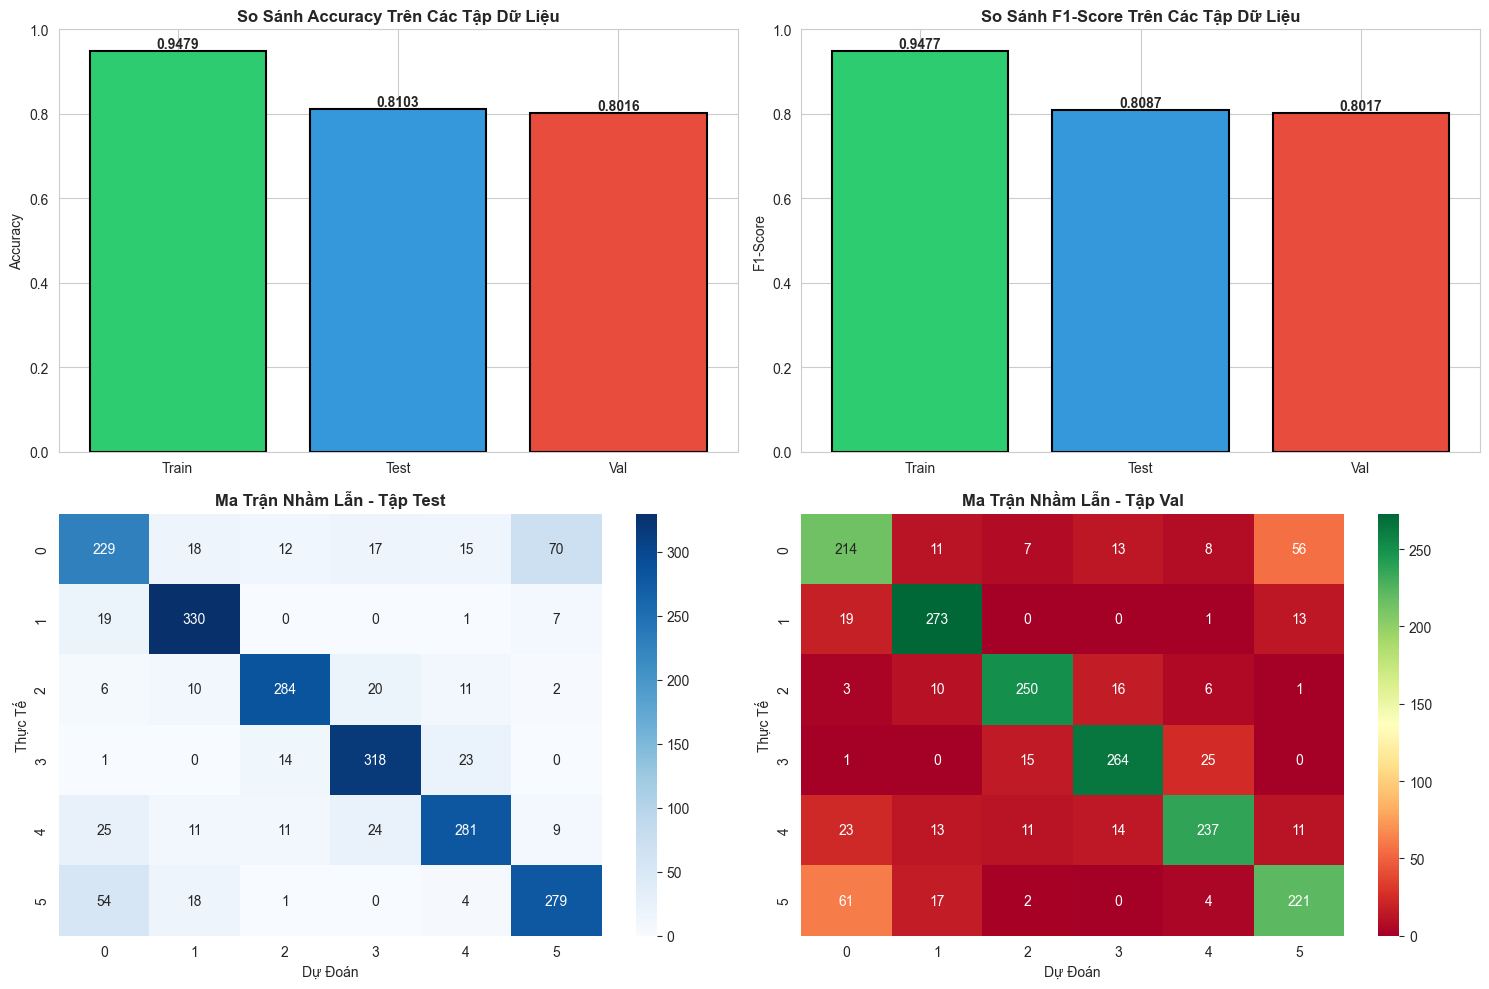

✓ Biểu đồ đã vẽ!


In [13]:
# 5.4: Biểu đồ các chỉ số hiệu suất
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. So sánh Accuracy
ax = axes[0, 0]
datasets = ['Train', 'Test', 'Val']
accuracies = [train_metrics['accuracy'], test_metrics['accuracy'], val_metrics['accuracy']]
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax.bar(datasets, accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax.set_title('So Sánh Accuracy Trên Các Tập Dữ Liệu', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. So sánh F1-Score
ax = axes[0, 1]
f1_scores = [train_metrics['f1_score'], test_metrics['f1_score'], val_metrics['f1_score']]
bars = ax.bar(datasets, f1_scores, color=colors, edgecolor='black', linewidth=1.5)
ax.set_title('So Sánh F1-Score Trên Các Tập Dữ Liệu', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score')
ax.set_ylim([0, 1])
for bar, f1 in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{f1:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Ma trận Nhầm Lẫn - Test
ax = axes[1, 0]
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
ax.set_title('Ma Trận Nhầm Lẫn - Tập Test', fontsize=12, fontweight='bold')
ax.set_xlabel('Dự Đoán')
ax.set_ylabel('Thực Tế')

# 4. Ma trận Nhầm Lẫn - Val
ax = axes[1, 1]
sns.heatmap(cm_val, annot=True, fmt='d', cmap='RdYlGn', cbar=True, ax=ax,
            xticklabels=range(num_classes), yticklabels=range(num_classes))
ax.set_title('Ma Trận Nhầm Lẫn - Tập Val', fontsize=12, fontweight='bold')
ax.set_xlabel('Dự Đoán')
ax.set_ylabel('Thực Tế')

plt.tight_layout()
plt.show()

print("✓ Biểu đồ đã vẽ!")

In [14]:
# 5.5: Báo cáo chi tiết
print("\n" + "="*70)
print("BÁO CÁO CHI TIẾT - PHÂN LOẠI TRÊN TẬP TEST")
print("="*70)

report = classification_report(y_test_split, y_test_pred,
                                target_names=[f'Lớp {i}' for i in range(num_classes)])
print("\n" + report)


BÁO CÁO CHI TIẾT - PHÂN LOẠI TRÊN TẬP TEST

              precision    recall  f1-score   support

       Lớp 0       0.69      0.63      0.66       361
       Lớp 1       0.85      0.92      0.89       357
       Lớp 2       0.88      0.85      0.87       333
       Lớp 3       0.84      0.89      0.87       356
       Lớp 4       0.84      0.78      0.81       361
       Lớp 5       0.76      0.78      0.77       356

    accuracy                           0.81      2124
   macro avg       0.81      0.81      0.81      2124
weighted avg       0.81      0.81      0.81      2124



## Bước 6: Phân Tích Feature Importance

In [15]:
# 6.1: Trích xuất Feature Importance
print("="*70)
print("PHÂN TÍCH TẦNG QUAN TRỌNG CỦA ĐẶC TRƯNG")
print("="*70)

# Lấy importance
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train_split.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n10 Đặc Trưng Quan Trọng Nhất:")
print("-"*70)
for idx, row in feature_importance_df.head(10).iterrows():
    print(f"{idx+1:2d}. {row['feature']:25s} {row['importance']:7.4f} {'█' * int(row['importance'] * 100)}")

print(f"\nTổng: {feature_importance_df['importance'].sum():.4f}")

PHÂN TÍCH TẦNG QUAN TRỌNG CỦA ĐẶC TRƯNG

10 Đặc Trưng Quan Trọng Nhất:
----------------------------------------------------------------------
 7. has_luxury_keyword         0.1775 █████████████████
 1. Final Price                0.1310 █████████████
 3. Area_m2                    0.1202 ████████████
 4. price_per_m2               0.1094 ██████████
 6. num_facilities             0.0864 ████████
21. has_kitchen                0.0661 ██████
 5. m2_per_person              0.0655 ██████
19. has_balcony                0.0316 ███
22. has_fridge                 0.0277 ██
 2. Max People                 0.0266 ██

Tổng: 1.0000


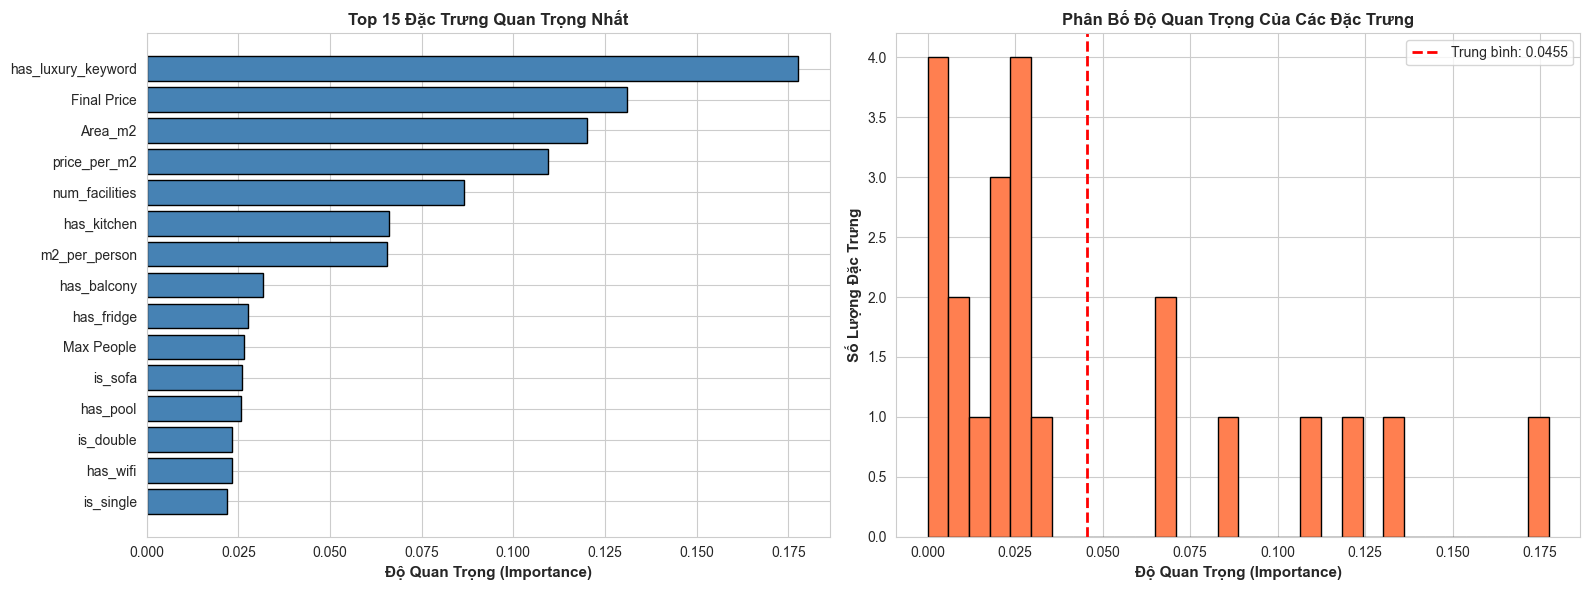

✓ Biểu đồ Importance đã vẽ!


In [16]:
# 6.2: Biểu đồ Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 đặc trưng quan trọng
ax = axes[0]
top_15 = feature_importance_df.head(15)
ax.barh(top_15['feature'], top_15['importance'], color='steelblue', edgecolor='black')
ax.set_xlabel('Độ Quan Trọng (Importance)', fontsize=11, fontweight='bold')
ax.set_title('Top 15 Đặc Trưng Quan Trọng Nhất', fontsize=12, fontweight='bold')
ax.invert_yaxis()

# Phân bố Importance
ax = axes[1]
ax.hist(feature_importance_df['importance'], bins=30, color='coral', edgecolor='black')
ax.set_xlabel('Độ Quan Trọng (Importance)', fontsize=11, fontweight='bold')
ax.set_ylabel('Số Lượng Đặc Trưng', fontsize=11, fontweight='bold')
ax.set_title('Phân Bố Độ Quan Trọng Của Các Đặc Trưng', fontsize=12, fontweight='bold')
ax.axvline(feature_importance_df['importance'].mean(), color='red', linestyle='--',
           linewidth=2, label=f"Trung bình: {feature_importance_df['importance'].mean():.4f}")
ax.legend()

plt.tight_layout()
plt.show()

print("✓ Biểu đồ Importance đã vẽ!")

## Bước 7: Lưu Mô Hình Đã Huấn Luyện

In [17]:
# 7.1: Tạo thư mục cho mô hình
print("="*70)
print("LƯU MÔ HÌNH ĐÃ HUẤN LUYỆN")
print("="*70)

model_dir = './Models'
os.makedirs(model_dir, exist_ok=True)

print(f"\nThư mục lưu mô hình: {model_dir}")

LƯU MÔ HÌNH ĐÃ HUẤN LUYỆN

Thư mục lưu mô hình: ./Models


In [18]:
# 7.2: Lưu mô hình
model_path = f'{model_dir}/random_forest_model.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

print(f"✓ Mô hình đã lưu: {model_path}")

✓ Mô hình đã lưu: ./Models/random_forest_model.pkl


In [19]:
# 7.3: Lưu các chỉ số hiệu suất
training_history = {
    'model_name': 'Random Forest',
    'model_params': rf_params,
    'training_time': training_time,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'val_metrics': val_metrics,
    'data_info': {
        'train_split_size': len(X_train_split),
        'test_split_size': len(X_test_split),
        'val_size': len(X_val),
        'num_features': X_train_split.shape[1],
        'num_classes': num_classes
    },
    'feature_importance': feature_importance_df.to_dict(orient='records')
}

history_path = f'{model_dir}/training_history.json'
with open(history_path, 'w') as f:
    json.dump(training_history, f, indent=2)

print(f"✓ Training history đã lưu: {history_path}")

✓ Training history đã lưu: ./Models/training_history.json


In [20]:
# 7.4: Lưu Feature Importance
importance_path = f'{model_dir}/feature_importance.csv'
feature_importance_df.to_csv(importance_path, index=False)

print(f"✓ Feature Importance đã lưu: {importance_path}")

✓ Feature Importance đã lưu: ./Models/feature_importance.csv


In [21]:
# 7.5: Tóm tắt huấn luyện
print("\n" + "="*70)
print("TÓM TẮT HUẤN LUYỆN MÔ HÌNH RANDOM FOREST")
print("="*70)

summary = f"""
┌─────────────────────────────────────────────────────────────────┐
│                    KẾT QUẢHUẤN LUYỆN                            │
└─────────────────────────────────────────────────────────────────┘

MÔ HÌNH:
  • Loại: Random Forest Classifier
  • Số cây: {rf_params['n_estimators']}
  • Độ sâu tối đa: {rf_params['max_depth']}
  • Thời gian huấn luyện: {training_time:.2f} giây

DỮ LIỆU:
  • Số đặc trưng: {X_train_split.shape[1]}
  • Số lớp: {num_classes}
  • Train split: {len(X_train_split)} mẫu (75%)
  • Test split: {len(X_test_split)} mẫu (25%)
  • Validation: {len(X_val)} mẫu

HIỆU SUẤT TRÊN TẬP TEST:
  • Accuracy:  {test_metrics['accuracy']:.4f}
  • Precision: {test_metrics['precision']:.4f}
  • Recall:    {test_metrics['recall']:.4f}
  • F1-Score:  {test_metrics['f1_score']:.4f}

HIỆU SUẤT TRÊN TẬP VALIDATION:
  • Accuracy:  {val_metrics['accuracy']:.4f}
  • Precision: {val_metrics['precision']:.4f}
  • Recall:    {val_metrics['recall']:.4f}
  • F1-Score:  {val_metrics['f1_score']:.4f}

ĐẶC TRƯNG QUAN TRỌNG NHẤT (Top 5):
"""

for idx, row in feature_importance_df.head(5).iterrows():
    summary += f"  {idx+1}. {row['feature']:25s} {row['importance']:.4f}\n"

summary += f"""
CÁC TẬP TIN ĐÃ LƯU:
  • Mô hình: {model_path}
  • Training history: {history_path}
  • Feature importance: {importance_path}

✨ Huấn luyện hoàn tất! Mô hình sẵn sàng để đánh giá và dự đoán. ✨
"""

print(summary)


TÓM TẮT HUẤN LUYỆN MÔ HÌNH RANDOM FOREST

┌─────────────────────────────────────────────────────────────────┐
│                    KẾT QUẢHUẤN LUYỆN                            │
└─────────────────────────────────────────────────────────────────┘

MÔ HÌNH:
  • Loại: Random Forest Classifier
  • Số cây: 200
  • Độ sâu tối đa: 20
  • Thời gian huấn luyện: 0.51 giây

DỮ LIỆU:
  • Số đặc trưng: 22
  • Số lớp: 6
  • Train split: 6371 mẫu (75%)
  • Test split: 2124 mẫu (25%)
  • Validation: 1820 mẫu

HIỆU SUẤT TRÊN TẬP TEST:
  • Accuracy:  0.8103
  • Precision: 0.8087
  • Recall:    0.8103
  • F1-Score:  0.8087

HIỆU SUẤT TRÊN TẬP VALIDATION:
  • Accuracy:  0.8016
  • Precision: 0.8026
  • Recall:    0.8016
  • F1-Score:  0.8017

ĐẶC TRƯNG QUAN TRỌNG NHẤT (Top 5):
  7. has_luxury_keyword        0.1775
  1. Final Price               0.1310
  3. Area_m2                   0.1202
  4. price_per_m2              0.1094
  6. num_facilities            0.0864

CÁC TẬP TIN ĐÃ LƯU:
  • Mô hình: ./Model